# Mask RCNN

# Import libraries & setup drive

In [ ]:
# Standard libraries & External
import os
import sys
import torch
import random
import pathlib

import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from PIL import Image
from skimage.io import imread
from google.colab import drive

from torch.nn.init import normal_
from torch.autograd import Variable
from torch.nn.parameter import Parameter

import torch.nn as nn
import torch.optim as optim
import torch.utils as tutils
import torch.nn.init as init
import torch.nn.functional as F

from torch.nn import Linear, Conv2d, ConvTranspose2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [ ]:
# Setup google drive for input data
drive.mount('/content/drive')
drive_path = 'drive/My Drive/Deep Learning - P9 - Cell Segmentation/Warwick_dataset_aug/'

# To be removed - only collate_fn from utils is used (and can be copied to this notebook)
# Setup additional libraries from google drive
# sys.path.append('/content/drive/MyDrive/Deep Learning - P9 - Cell Segmentation/neededFilesForFAST_RCNN')

# import utils
# import coco_eval
# import coco_utils
# import engine
# import transforms

def collate_fn(batch):
    return tuple(zip(*batch))

Mounted at /content/drive


# Dataloader:

#### Dataset class:

In [ ]:
def get_images(input_path, testA=False, testB=False, test=False):
    # Finds input images in input directory
    input_files = pathlib.Path(input_path).iterdir()
    images = [img for img in input_files 
              if img.suffix == '.bmp' and 'anno' not in img.name]
    if test:
        images = [img for img in images if 'test' in img.name]
    elif testA:
        images = [img for img in images if 'testA' in img.name]
    elif testB:
        images = [img for img in images if 'testB' in img.name]
    else:
        images = [img for img in images if 'test' not in img.name]

    # Calculates chanel wise statistics for normalization
    meansR,meansG,meansB = [],[],[]
    stdsR,stdsG,stdsB = [],[],[]
    for i in range(0,len(images)):
        print(i)
        im = imread(str(images[i]))
        meansR.append(np.mean(im[:,:,0]))
        meansG.append(np.mean(im[:,:,1]))
        meansB.append(np.mean(im[:,:,2]))
        stdsR.append(np.std(im[:,:,0]))
        stdsG.append(np.std(im[:,:,1]))
        stdsB.append(np.std(im[:,:,2]))

        meanR = np.mean(meansR)
        meanG = np.mean(meansG)
        meanB = np.mean(meansB)
        means = [meanR, meanG, meanB]

        stdR = np.mean(stdsR)
        stdG = np.mean(stdsG)
        stdB = np.mean(stdsB)
        stds = [stdR, stdG, stdB]
    return means, stds, images

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, input_path, testA=False, testB=False, test=False):
        means, stds, images = get_images(input_path, testA, testB, test)
        self.images = images
        self.means = means
        self.stds = stds

    def __len__(self):
        return len(self.images)

    def _normalize(self, image):
        a = (image[:,:,0] - self.means[0])/self.stds[0]
        b = (image[:,:,1] - self.means[1])/self.stds[1]
        c = (image[:,:,2] - self.means[2])/self.stds[2]
        return np.stack((a,b,c))

    def _binary_masks(self, mask):
        # Creates multiple masks per each unique
        # value (minus background) in input mask
        class_ids = np.unique(mask)[1:]
        return mask == class_ids[:, None, None]
  
    def _bounding_box(self, masks):
        boxes = []
        for index, mask in enumerate(masks):
            pos = np.where(mask)
            xmin, ymin = np.min(pos[1]), np.min(pos[0])
            xmax, ymax = np.max(pos[1]), np.max(pos[0])
            if (xmax - xmin > 0) and (ymax - ymin > 0):
                boxes.append([xmin, ymin, xmax, ymax])
        return boxes

    def __getitem__(self, index):
        img = self.images[index]
        X_np = imread(str(img))
        y_np = imread(str(img.parent / (img.stem + '_anno.bmp')), as_gray=True)

        image = self._normalize(X_np)
        masks = self._binary_masks(y_np)
        boxes = self._bounding_box(masks)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        target = {}
        # target['name'] = img.stem
        # target['test'] = X_np
        target["boxes"] = boxes
        target["labels"] = torch.ones((len(masks),), dtype=torch.int64)
        target["masks"] = torch.as_tensor(masks, dtype=torch.uint8)
        target["image_id"] = torch.tensor([index])
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # target["area"] = boxes[:,3]*0+1
        # target["iscrowd"] = torch.zeros((len(masks),), dtype=torch.int64)
        X = torch.from_numpy(image.astype('float32'))

        return X, target

#### Testing dataloader:

In [ ]:
training_set = Dataset(drive_path)
training_generator = torch.utils.data.DataLoader(
    training_set, batch_size=1, shuffle=True)

KeyboardInterrupt: ignored

batch: torch.Size([1, 3, 512, 512])
masks: torch.Size([1, 9, 512, 512])
labels: torch.Size([1, 9])
boxes: torch.Size([1, 9, 4])
tensor([[  3965.,   1044.,  11346., 120150.,   9222.,   7387.,   5002.,  26730.,
           9156.]])


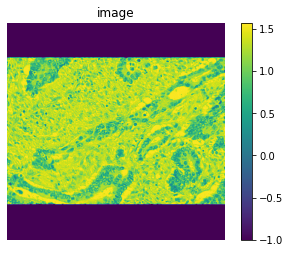

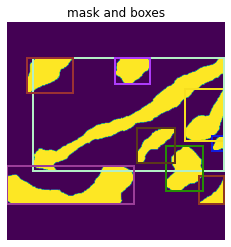

In [ ]:
for batch, target in training_generator:
    batch = batch.cpu()
    masks = target['masks'].cpu()
    labels = target['labels'].cpu()
    boxes = target['boxes'].cpu()
    print(f"batch: {batch.shape}")
    print(f"masks: {masks.shape}")
    print(f"labels: {labels.shape}")
    print(f"boxes: {boxes.shape}")

    plt.figure()
    plt.imshow(batch[0,0,:,:])
    plt.colorbar()
    plt.title('image')
    plt.axis('off')

    # plt.figure()
    # plt.imshow(target['test'].squeeze())
    # plt.colorbar()
    # plt.title('image')
    # plt.axis('off')

    print(target['area'])

    fig,ax = plt.subplots()
    ax.imshow(torch.sum(masks,axis=1)[0,:,:])  # sum because masks are saved as stack, one layer per patch
    plt.title('mask and boxes')
    plt.axis('off')
    for i in range(0,boxes.shape[1]):
        rect = patches.Rectangle(
            (boxes[0,i,0],boxes[0,i,1]),
            (boxes[0,i,2]-boxes[0,i,0]),
            (boxes[0,i,3]-boxes[0,i,1]),
            linewidth=2,
            edgecolor=[random.random(),random.random(),random.random()],
            facecolor='none'
        )
        ax.add_patch(rect)
    break

# Model:

#### Model setup

In [ ]:
def create_model():
    # Backbone ResNet50 model pre-trained on COCO
    # Generates feature maps from input images (used by RPN and Mask Predictor)
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)

    # Region Proposal Network (RPN)
    # Generates Regions of Interest (ROI) and its class
    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Mask predictor
    hidden_layer = 256
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes)

    model.to(torch.device('cuda'))
    return model

def create_model2():
    # Outputs just boxes without masks
    backbone = torchvision.models.mobilenet_v2(pretrained=True).features
    backbone.out_channels = 1280
    num_classes = 2
    anchor_generator = AnchorGenerator(
        sizes=((4, 8, 16, 128, 256),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=["0"],
        output_size=7,
        sampling_ratio=2
    )
    model = FasterRCNN(
        backbone, num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )
    hidden_layer = 256
    in_features_mask = backbone.out_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes
    )
    model.to(torch.device('cuda'))
    return model


#### Test model training & inference

In [ ]:
batch_size = 2

training_set = Dataset(drive_path)
testA_set = Dataset(drive_path, testA=True)
testB_set = Dataset(drive_path, testB=True)

train_size = int(0.9 * len(training_set))
valid_size = len(training_set) - train_size
training_set, valid_set = tutils.data.random_split(
    training_set, [train_size, valid_size])

training_generator = torch.utils.data.DataLoader(
    training_set, batch_size=batch_size,
    shuffle=True, num_workers=4,
    collate_fn=collate_fn
)

validation_generator = torch.utils.data.DataLoader(
    valid_set, batch_size=batch_size,
    shuffle=False, num_workers=4,
    collate_fn=collate_fn
)

# testA_generator = torch.utils.data.DataLoader(
#     testA_set, batch_size=batch_size,
#     shuffle=False, num_workers=4,
#     collate_fn=collate_fn
# )

# testB_generator = torch.utils.data.DataLoader(
#     testB_set, batch_size=batch_size,
#     shuffle=False, num_workers=4,
#     collate_fn=collate_fn
# )

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
model = create_model()

# Test training
for batch, target in training_generator:
    images = list(image.cuda() for image in batch)
    targets = [{k: v.cuda() for k, v in t.items()} for t in target]
    output = model(images, targets)
    print(output)

    # Test inference
    model.eval()
    x = [torch.rand(3, 300, 400).cuda(), torch.rand(3, 500, 400).cuda()]
    predictions = model(x)
    # print(predictions)
    break

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


{'loss_classifier': tensor(1.3236, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.2553, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(4.5282, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_objectness': tensor(0.1854, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0257, device='cuda:0', grad_fn=<DivBackward0>)}


#### Train model

In [ ]:
# del model
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
# it is in fact test data
validation_2_set = Dataset(drive_path, test=True)
validation_2_generator = torch.utils.data.DataLoader(
    validation_2_set, batch_size=2,
    shuffle=True, num_workers=4,
    collate_fn=collate_fn
)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
# Prepare model, optimizer and lr scheduler (optional)
# https://arxiv.org/pdf/1805.00500.pdf (methodology)
model = create_model()
optimizer = optim.SGD(
    [p for p in model.parameters() if p.requires_grad],
    lr=0.0001, momentum=0.9, weight_decay=0.0003
)
# optimizer = optim.Adam(
#     [p for p in model.parameters() if p.requires_grad],
#     lr=1e-4, weight_decay=0.0005
# )
lr_scheduler = optim.lr_scheduler.StepLR(
    optimizer, step_size=15, gamma=0.1
)

# Loss function aggregator
class Averager:
    # https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        self.save = []

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.save.append(self.value)
        self.current_total = 0.0
        self.iterations = 0.0


# Run Training loop
loss_hist = Averager()
valid_loss_hist = Averager()
testA_loss_hist = Averager()
testB_loss_hist = Averager()
epochs = 60
for epoch in range(epochs):
    for images, targets in training_generator:
        images = list(image.cuda() for image in images)
        targets = [{k: v.cuda() for k, v in t.items()} for t in targets]

        model.train()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_hist.send(losses.item())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    cntr = 0
    for images, targets in validation_2_generator:
        if (cntr % 4 != 0):
            continue
        images = list(image.cuda() for image in images)
        targets = [{k: v.cuda() for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            valid_loss_dict = model(images, targets)
            valid_losses = sum(loss for loss in valid_loss_dict.values())
            valid_loss_hist.send(valid_losses.item())
        cntr += 1
    
    # for images, targets in testA_generator:
    #     images = list(image.cuda() for image in images)
    #     targets = [{k: v.cuda() for k, v in t.items()} for t in targets]
        
    #     with torch.no_grad():
    #         testA_loss_dict = model(images, targets)
    #         testA_losses = sum(loss for loss in testA_loss_dict.values())
    #         testA_loss_hist.send(testA_losses.item())
    
    # for images, targets in testB_generator:
    #     images = list(image.cuda() for image in images)
    #     targets = [{k: v.cuda() for k, v in t.items()} for t in targets]
        
    #     with torch.no_grad():
    #         testB_loss_dict = model(images, targets)
    #         testB_losses = sum(loss for loss in testB_loss_dict.values())
    #         testB_loss_hist.send(testB_losses.item())


    print(f"Epoch #{epoch + 1} Train Loss: {loss_hist.value} Validation Loss: {valid_loss_hist.value}")
    # print(f"\t TestA Loss: {testA_loss_hist.value} TestB: {testB_loss_hist.value}")
    lr_scheduler.step()
    loss_hist.reset()
    valid_loss_hist.reset()
    # testA_loss_hist.reset()
    # testB_loss_hist.reset()

    if (epoch % 5 == 0):
        print('Saving...')
        save1 = pathlib.Path(drive_path).parent / 'MRCNN_3_FIN'
        save2 = pathlib.Path(drive_path).parent / 'MRCNN_3_FIN'
        torch.save(model.state_dict(), str(save1))
        torch.save(model, str(save2))


save1 = pathlib.Path(drive_path).parent / 'MRCNN_3_FIN'
save2 = pathlib.Path(drive_path).parent / 'MRCNN_3_FIN'
torch.save(model.state_dict(), str(save1))
torch.save(model, str(save2))

print(loss_hist.save)
print(valid_loss_hist.save)
# print(testA_loss_hist.save)
# print(testB_loss_hist.save)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch #1 Train Loss: 1.7110151946544647 Validation Loss: 1.7560118436813354
Saving...
Epoch #2 Train Loss: 1.3024287247139474 Validation Loss: 0.9387750029563904
Epoch #3 Train Loss: 1.0365350536678148 Validation Loss: 1.0179553031921387
Epoch #4 Train Loss: 0.8987344529317773 Validation Loss: 0.904891312122345
Epoch #5 Train Loss: 0.8284981038259424 Validation Loss: 0.5971939563751221
Epoch #6 Train Loss: 0.7618838373733603 Validation Loss: 0.9640300273895264
Saving...
Epoch #7 Train Loss: 0.730206307898397 Validation Loss: 1.5051695108413696
Epoch #8 Train Loss: 0.6820225330798523 Validation Loss: 1.2915955781936646
Epoch #9 Train Loss: 0.6577393196199252 Validation Loss: 1.2064639329910278
Epoch #10 Train Loss: 0.6274135932974193 Validation Loss: 0.37347492575645447
Epoch #11 Train Loss: 0.596687000601188 Validation Loss: 1.0511534214019775
Saving...
Epoch #12 Train Loss: 0.584143087786177 Validation Loss: 1.4835073947906494
Epoch #13 Train Loss: 0.5611010337005491 Validation Loss: 

In [ ]:
# FIN_1 (step_size=5)
train_l = [1.5032523427320563, 1.1498337087423904, 0.9519966768181842, 0.8614950415880783, 0.7909284029317939, 0.7367417164470839, 0.727907962254856, 0.7246435581342033, 0.7204255057417828, 0.7172412054694217, 0.7062583081100298, 0.7060146430264349, 0.7065945051286532, 0.707225603642671, 0.7043657787468123, 0.7027367604815442, 0.7019067796676055, 0.7033204498498337, 0.7012988113838693, 0.7012694927661315]
test_l  = [1.2452846605044146, 0.9073998607121981, 0.887512573829064, 0.7799023332504126, 0.7373125312420038, 0.7396487479026501, 0.740668868789306, 0.7272353057677929, 0.7277534741621751, 0.7224194636711707, 0.7204038363236648, 0.7216772780968592, 0.722371383355214, 0.7228313650076206, 0.7222394072092496, 0.7218109644376315, 0.7186211129793754, 0.7200465167944248, 0.7205976419723951, 0.7212215409829066]
# FIN_2 (step_size=9)
train_2 = [1.6388861428136412, 1.3005071520805358, 1.0477560945179152, 0.9242001959811086, 0.8355224118284558, 0.7838805812856425, 0.7331140174813893, 0.6992588555035384, 0.6605338399824889, 0.6246399125327234, 0.6164915956232859, 0.61313373018866, 0.6124358537404434, 0.6027855954740359, 0.60598183028076, 0.6061632673377576, 0.6003498212150905, 0.5970209901747496, 0.5910103729237681, 0.5925500522489133]
test_2 = [1.3400335747462053, 0.9811732104191413, 0.9458706447711358, 0.8430374035468469, 0.8275114148855209, 0.7235955217709908, 0.7539661606917014, 0.7036551317343345, 0.7013073403101701, 0.6961594739785562, 0.6913926418011005, 0.6898823403395139, 0.6847470345405432, 0.6948357098377668, 0.6929025948047638, 0.6869875135330054, 0.6846284293211423, 0.6948389594371502, 0.6913054023797696, 0.6940858008769842]

In [ ]:
# save1 = pathlib.Path(drive_path).parent / 'MRCNN_2_state'
# save2 = pathlib.Path(drive_path).parent / 'MRCNN_2_full'
# torch.save(model.state_dict(), str(save1))
# torch.save(model, str(save2))
# print(loss_hist.save)
# print(valid_loss_hist.save)

[1.451659040318595, 1.0237585863832273, 0.8691695080411554, 0.7946892399529014, 0.7389283914006117, 0.6940047370665001, 0.6657526831735264, 0.6418462284661904, 0.6198818422101363, 0.5947388937753258]
[1.1355582252897398, 0.9823625774094553, 0.8822668808879275, 0.7908998276248123, 0.7704191815973532, 0.7544337255184097, 0.7247599396440718, 0.6917658619808428, 0.713175956347976, 0.6998743875460192]


In [ ]:
# MRCNN_3 80 epochs (trained on testing also)
# [1.4536321387447493, 1.017738962263772, 0.8659178033621624, 0.7787524080938764, 0.7289322961610977, 0.6891312849039983, 0.6625399393114176, 0.6297247612265625, 0.6045515970750288, 0.5850119638172063, 0.5602731182418689, 0.546935048368242, 0.5289301898593854, 0.5158954955110646, 0.4938705733252896, 0.48236418884209914, 0.46703765018269267, 0.4533635781268881, 0.4478178113473184, 0.4344387794233332, 0.4149515756001376, 0.40903637272239934, 0.40789349437362016, 0.4061822663955014, 0.4054137176711752, 0.40287713138292536, 0.403599675180334, 0.4026905686566324, 0.40030737383046533, 0.4001594754406298, 0.399911502131609, 0.39757949776119655, 0.39517850650831904, 0.39621155776760797, 0.3948791132430838, 0.39447269231231524, 0.392817859773082, 0.39218710351622466, 0.39129208867447546, 0.3888053329981337, 0.38712398734207104, 0.38535721509745624, 0.3872575526210395, 0.386767018360622, 0.3859893240486131, 0.3861224809379289, 0.38547093210497285, 0.3867247617906994, 0.38595769099063343, 0.3853941643328378, 0.38602780204529713, 0.38507582337567303, 0.38617824311509275, 0.3861905312673612, 0.384459886323623, 0.3842371516682283, 0.38556516949426045, 0.3850988464599306, 0.38493200572151126, 0.38630320455389794, 0.38429166636232176, 0.38350832229009785, 0.385772289087375, 0.38601910631463987, 0.385604110480559, 0.3851599505904949, 0.3842527341059964, 0.3825353038958227, 0.3849906940577608, 0.3859679257177343, 0.3849779968761434, 0.3843880720963382, 0.3852185229535657, 0.3863611870417089, 0.38490858406882095, 0.3845521093092181, 0.38465052662473737, 0.3848411093155543, 0.38446466334991986, 0.3832013476075548]
# [1.2222240163822367, 0.990254336234295, 0.8969774044523335, 0.8515442922861889, 0.8337472517683049, 0.8219069362890841, 0.7701897431503643, 0.7403971471569755, 0.7488174435466227, 0.7538412595638121, 0.7692680873654105, 0.7676031923655308, 0.7325747931244397, 0.7316132058398892, 0.7365391898636866, 0.7491416094279049, 0.7391908481867626, 0.7738778282596608, 0.7462009188502726, 0.7475997060537338, 0.7481479015615251, 0.7536445071901938, 0.7534528389723614, 0.7616488185494837, 0.7554858572254277, 0.7582843044791558, 0.7564658475945695, 0.7588284992509418, 0.763508366514938, 0.7589316884375582, 0.7619472520821022, 0.7639108456746496, 0.7670609693635594, 0.7615408873317218, 0.7672666436192965, 0.7727004960931912, 0.7679710293358023, 0.7696125823439974, 0.7682789791413028, 0.7709122936833989, 0.7727603114614583, 0.7703169378066304, 0.76708610310699, 0.771656516224447, 0.7661022879559585, 0.7680708439362169, 0.7700183254600775, 0.7711671831631901, 0.7675271338284618, 0.7723380647825472, 0.7707016808216018, 0.7680857198105918, 0.770778340522689, 0.7727799861118047, 0.7709797768279759, 0.7717628625005183, 0.7695493857667903, 0.7704423054902241, 0.7707433589179107, 0.7710360270557981, 0.7730242679215441, 0.7710131001893921, 0.7668367890697537, 0.772991237014231, 0.7712000933560458, 0.7703935103585021, 0.7706933408373534, 0.7726630613659368, 0.7751282157018932, 0.7705769690901342, 0.771309159470327, 0.7677675252309953, 0.7729719847139686, 0.7732559078269534, 0.7715033524566226, 0.7724255869785944, 0.7730725372981544, 0.7692660064709307, 0.7705170719912557, 0.7674103621581588]

#### Evaluate model

In [ ]:
def get_mask(prediction, box_threshold=0.4, pixel_threshold=0.9):
    # box_threshold - min probability of overlapping box
    # pixel_threshold - min probability sum (can be larger than 1) over all masks of pixel being cell
    # Input:  Mask RCNN prediction
    # Output: Binary Image
    pred_boxes = predictions[0]['boxes']
    pred_masks = predictions[0]['masks']
    scores = predictions[0]['scores']

    keep = torchvision.ops.nms(pred_boxes, scores, box_threshold)

    pred_masks = pred_masks.squeeze()
    pred_masks = torch.index_select(pred_masks, 0, keep).cpu().detach().numpy()
    pred_masks = np.where(pred_masks >= 0.3, pred_masks, 0)
    pred_masks = pred_masks.sum(0)
    pred_masks = np.where(pred_masks >= pixel_threshold, 1, 0)
    return pred_masks

In [ ]:
test_set = Dataset(drive_path, test=True)
test_generator = torch.utils.data.DataLoader(
    test_set, batch_size=1,
    shuffle=False, num_workers=4
)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
# model = torch.load(pathlib.Path(drive_path).parent / 'MRCNN_3_full')
model.eval()
threshold = 0.3  # class probability threshold
from PIL import Image

for batch, target in test_generator:
    # masks = target['masks'].cpu()
    # labels = target['labels'].cpu()
    # boxes = target['boxes'].cpu()

    # # Show true image
    # plt.figure()
    # plt.imshow(batch[0,0,:,:].cpu())
    # plt.colorbar()
    # plt.title('image')
    # plt.axis('off')

    # Show true mask with true boxes
    # plt.figure()
    # fig,ax = plt.subplots()
    # ax.imshow(torch.sum(masks,axis=1)[0,:,:])
    # plt.title('True mask and boxes')
    # plt.axis('off')
    # for i in range(0, boxes.shape[1]):
    #     rect = patches.Rectangle(
    #         (boxes[0,i,0],boxes[0,i,1]),
    #         (boxes[0,i,2]-boxes[0,i,0]),
    #         (boxes[0,i,3]-boxes[0,i,1]),
    #         linewidth=2,
    #         edgecolor=[random.random(),random.random(),random.random()],
    #         facecolor='none'
    #     )
    #     ax.add_patch(rect)

    # Model inference
    predictions = model(batch.cuda())
    mask = get_mask(predictions)
    # print(mask)
    img = Image.fromarray(np.uint8(mask))
    main = pathlib.Path(drive_path).parent
    img.save(str(main / f'Warwick_mrcnn_output/{target["name"][0]}.bmp'))

    # print(predictions)
    # pred_boxes = predictions[0]['boxes']
    # pred_masks = predictions[0]['masks']
    # scores = predictions[0]['scores']
    
    # Non-maximum suppression to remove small & overlapping boxes with lower probability
    # https://towardsdatascience.com/everything-about-fasterrcnn-6d758f5a6d79
    # keep = torchvision.ops.nms(pred_boxes, scores, threshold)

    # Show true mask and prediction boxes
    # plt.figure()
    # fig,ax = plt.subplots()
    # ax.imshow(torch.sum(masks,axis=1)[0,:,:])
    # plt.title('True mask and output boxes')
    # plt.axis('off')
    # for i in range(0,pred_boxes.shape[0]):
    #     if i not in keep:
    #         continue
    #     rect = patches.Rectangle(
    #         (pred_boxes[i,0],pred_boxes[i,1]),
    #         (pred_boxes[i,2]-pred_boxes[i,0]),
    #         (pred_boxes[i,3]-pred_boxes[i,1]),
    #         linewidth=2,
    #         edgecolor=[random.random(),random.random(),random.random()],
    #         facecolor='none'
    #     )
    #     ax.add_patch(rect)
    
    # Show prediction segmentation mask with high pixel probability for any class
    # pred_masks = pred_masks.squeeze()
    # pred_masks = torch.index_select(pred_masks, 0, keep).cpu().detach().numpy()
    # pred_masks = np.where(pred_masks >= 0.4, pred_masks, 0)
    # pred_masks = pred_masks.sum(0)
    # pred_masks = np.where(pred_masks >= 0.9, 1, 0)
    # plt.figure()
    # plt.imshow(pred_masks)
    # plt.title('Output mask')
    # plt.axis('off')

    # break